In [1]:
from efficientnet_pytorch import EfficientNet
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torch
from torchvision import datasets, transforms as T
import torchvision
import time
import copy
import os

In [2]:
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [3]:
model.fc = torch.nn.Sequential(torch.nn.Linear(in_features=1280,
                                               out_features=2))


In [4]:
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
from torch.utils.data import Dataset
use_cuda = False

trans = torchvision.transforms.Compose(
[
    torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

data_dir = './New Masks DatasetFull/Face Mask Dataset'
MODEL_STORE_PATH = './'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'faces': transforms.Compose([
#         transforms.RandomResizedCrop(64),
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}
def get_dataset(data_dir, data_transforms ):
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes
train_dataloader, test_dataloader , classes, dataset_sizes=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: './New Masks DatasetFull/Face Mask Dataset\\train'

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

net = model
net = net.cuda() if device else net

In [31]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'EN.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/5], Step [0/3305], Loss: 0.5135
Epoch [1/5], Step [20/3305], Loss: 0.0848
Epoch [1/5], Step [40/3305], Loss: 0.2706
Epoch [1/5], Step [60/3305], Loss: 0.0485
Epoch [1/5], Step [80/3305], Loss: 0.1432
Epoch [1/5], Step [100/3305], Loss: 0.6778
Epoch [1/5], Step [120/3305], Loss: 0.4374
Epoch [1/5], Step [140/3305], Loss: 0.2892
Epoch [1/5], Step [160/3305], Loss: 0.5357
Epoch [1/5], Step [180/3305], Loss: 0.3870
Epoch [1/5], Step [200/3305], Loss: 0.0650
Epoch [1/5], Step [220/3305], Loss: 0.2568
Epoch [1/5], Step [240/3305], Loss: 0.0802
Epoch [1/5], Step [260/3305], Loss: 0.1081
Epoch [1/5], Step [280/3305], Loss: 0.0958
Epoch [1/5], Step [300/3305], Loss: 0.0357
Epoch [1/5], Step [320/3305], Loss: 0.3079
Epoch [1/5], Step [340/3305], Loss: 0.5774
Epoch [1/5], Step [360/3305], Loss: 0.0474
Epoch [1/5], Step [380/3305], Loss: 0.0939
Epoch [1/5], Step [400/3305], Loss: 0.0380
Epoch [1/5], Step [420/3305], Loss: 0.0575
Epoch [1/5], Step [440/3305], Loss: 0.1516
Epoch [1

Epoch [2/5], Step [380/3305], Loss: 0.1048
Epoch [2/5], Step [400/3305], Loss: 0.6186
Epoch [2/5], Step [420/3305], Loss: 0.0277
Epoch [2/5], Step [440/3305], Loss: 0.0256
Epoch [2/5], Step [460/3305], Loss: 0.0127
Epoch [2/5], Step [480/3305], Loss: 0.3613
Epoch [2/5], Step [500/3305], Loss: 0.2357
Epoch [2/5], Step [520/3305], Loss: 0.6501
Epoch [2/5], Step [540/3305], Loss: 0.2594
Epoch [2/5], Step [560/3305], Loss: 0.0135
Epoch [2/5], Step [580/3305], Loss: 0.0081
Epoch [2/5], Step [600/3305], Loss: 0.3976
Epoch [2/5], Step [620/3305], Loss: 0.0081
Epoch [2/5], Step [640/3305], Loss: 0.1520
Epoch [2/5], Step [660/3305], Loss: 0.0223
Epoch [2/5], Step [680/3305], Loss: 0.0331
Epoch [2/5], Step [700/3305], Loss: 0.1600
Epoch [2/5], Step [720/3305], Loss: 0.0145
Epoch [2/5], Step [740/3305], Loss: 0.4404
Epoch [2/5], Step [760/3305], Loss: 0.0466
Epoch [2/5], Step [780/3305], Loss: 0.1989
Epoch [2/5], Step [800/3305], Loss: 0.0584
Epoch [2/5], Step [820/3305], Loss: 0.1752
Epoch [2/5]

Epoch [3/5], Step [760/3305], Loss: 0.2391
Epoch [3/5], Step [780/3305], Loss: 0.0075
Epoch [3/5], Step [800/3305], Loss: 0.2542
Epoch [3/5], Step [820/3305], Loss: 0.0141
Epoch [3/5], Step [840/3305], Loss: 0.0596
Epoch [3/5], Step [860/3305], Loss: 0.0430
Epoch [3/5], Step [880/3305], Loss: 0.0170
Epoch [3/5], Step [900/3305], Loss: 0.0237
Epoch [3/5], Step [920/3305], Loss: 0.0499
Epoch [3/5], Step [940/3305], Loss: 0.0250
Epoch [3/5], Step [960/3305], Loss: 2.3119
Epoch [3/5], Step [980/3305], Loss: 0.1527
Epoch [3/5], Step [1000/3305], Loss: 0.6444
Epoch [3/5], Step [1020/3305], Loss: 0.0298
Epoch [3/5], Step [1040/3305], Loss: 0.1708
Epoch [3/5], Step [1060/3305], Loss: 0.3275
Epoch [3/5], Step [1080/3305], Loss: 0.5504
Epoch [3/5], Step [1100/3305], Loss: 0.0724
Epoch [3/5], Step [1120/3305], Loss: 0.0281
Epoch [3/5], Step [1140/3305], Loss: 0.0270
Epoch [3/5], Step [1160/3305], Loss: 0.0119
Epoch [3/5], Step [1180/3305], Loss: 0.0481
Epoch [3/5], Step [1200/3305], Loss: 0.0243


Epoch [4/5], Step [1140/3305], Loss: 0.2290
Epoch [4/5], Step [1160/3305], Loss: 0.0330
Epoch [4/5], Step [1180/3305], Loss: 0.0158
Epoch [4/5], Step [1200/3305], Loss: 0.1000
Epoch [4/5], Step [1220/3305], Loss: 0.2974
Epoch [4/5], Step [1240/3305], Loss: 0.0901
Epoch [4/5], Step [1260/3305], Loss: 0.0889
Epoch [4/5], Step [1280/3305], Loss: 0.0102
Epoch [4/5], Step [1300/3305], Loss: 0.0077
Epoch [4/5], Step [1320/3305], Loss: 0.1974
Epoch [4/5], Step [1340/3305], Loss: 0.0116
Epoch [4/5], Step [1360/3305], Loss: 0.0069
Epoch [4/5], Step [1380/3305], Loss: 0.0275
Epoch [4/5], Step [1400/3305], Loss: 0.0303
Epoch [4/5], Step [1420/3305], Loss: 0.0269
Epoch [4/5], Step [1440/3305], Loss: 0.0133
Epoch [4/5], Step [1460/3305], Loss: 0.0182
Epoch [4/5], Step [1480/3305], Loss: 0.0071
Epoch [4/5], Step [1500/3305], Loss: 0.1654
Epoch [4/5], Step [1520/3305], Loss: 0.4044
Epoch [4/5], Step [1540/3305], Loss: 1.7562
Epoch [4/5], Step [1560/3305], Loss: 0.2337
Epoch [4/5], Step [1580/3305], L

Epoch [5/5], Step [1520/3305], Loss: 0.0372
Epoch [5/5], Step [1540/3305], Loss: 0.0500
Epoch [5/5], Step [1560/3305], Loss: 0.0170
Epoch [5/5], Step [1580/3305], Loss: 0.0865
Epoch [5/5], Step [1600/3305], Loss: 0.0241
Epoch [5/5], Step [1620/3305], Loss: 0.1490
Epoch [5/5], Step [1640/3305], Loss: 0.1131
Epoch [5/5], Step [1660/3305], Loss: 0.0373
Epoch [5/5], Step [1680/3305], Loss: 0.0117
Epoch [5/5], Step [1700/3305], Loss: 0.0143
Epoch [5/5], Step [1720/3305], Loss: 0.0039
Epoch [5/5], Step [1740/3305], Loss: 0.0221
Epoch [5/5], Step [1760/3305], Loss: 0.1505
Epoch [5/5], Step [1780/3305], Loss: 0.1549
Epoch [5/5], Step [1800/3305], Loss: 0.0141
Epoch [5/5], Step [1820/3305], Loss: 0.7248
Epoch [5/5], Step [1840/3305], Loss: 0.0095
Epoch [5/5], Step [1860/3305], Loss: 0.4600
Epoch [5/5], Step [1880/3305], Loss: 0.0163
Epoch [5/5], Step [1900/3305], Loss: 0.0280
Epoch [5/5], Step [1920/3305], Loss: 0.0416
Epoch [5/5], Step [1940/3305], Loss: 0.0079
Epoch [5/5], Step [1960/3305], L

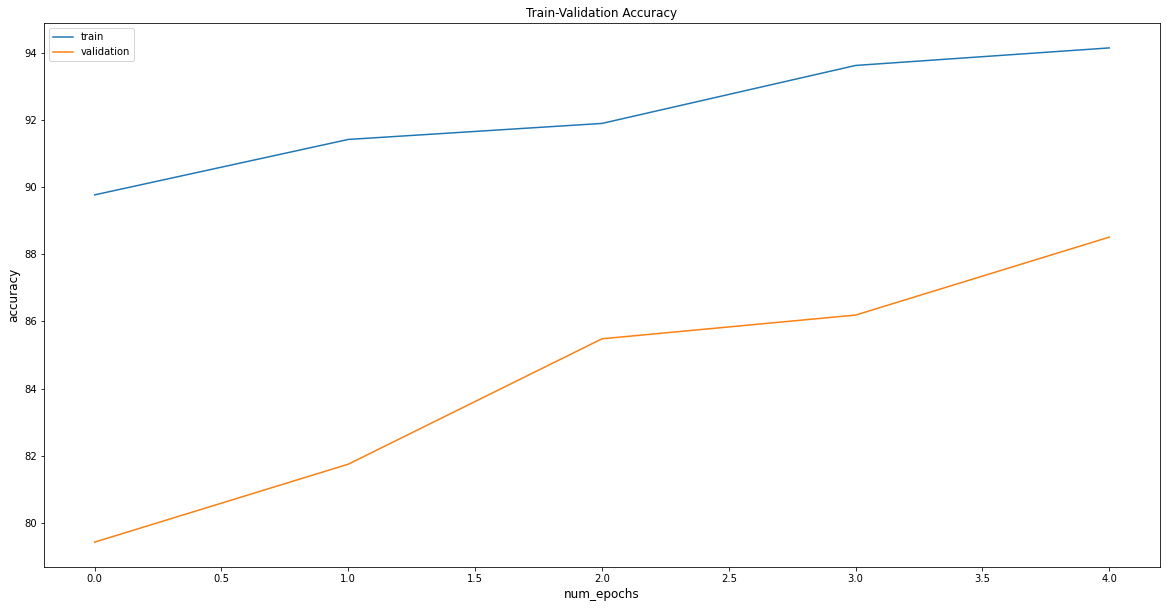

In [32]:
import matplotlib.pyplot as plt
ig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [33]:
from matplotlib.pyplot import * 
from PIL import Image
from torch.utils.data import Dataset
use_cuda = True

trans = torchvision.transforms.Compose(
[
    torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [34]:
net.load_state_dict(torch.load('EN.pt'))
test_dataset = torchvision.datasets.ImageFolder(root='./New Masks Dataset/Face Mask Dataset/Validation', transform=trans)
data_dir_valid = './New Masks Dataset/Face Mask Dataset/Validation'
MODEL_STORE_PATH = './'
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'tesst': transforms.Compose([
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}

train_dataloader1, test_dataloader1 , classes1, dataset_sizes1=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes1)

Classes:  ['WithMask', 'WithoutMask']


In [35]:
from torch.utils.data import Dataset

use_cuda = True
import time

TPR = []
FPR = []
dataLable = []
predict = []

inp = []
out = []


def model_metric(net):
    alls = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    j = 0
    time1 = 0
    batch = 4
    loss = 0
    for i, data in enumerate(train_dataloader1):
        j += batch
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
            if inputs.shape[0] != batch:
                continue
        start_time = time.time()
        outputs = net(inputs)
        time1 += (time.time() - start_time)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()

        for j in range(0, batch - 1):
            inp.append(labels[j])
            out.append(preds[j])
            if ((labels[j] == preds[j]) and (preds[j] == 1)): tp += 1
            if ((labels[j] != preds[j]) and (preds[j] == 1)): fp += 1
            if ((labels[j] != preds[j]) and (preds[j] == 0)): fn += 1
            if ((labels[j] == preds[j]) and (preds[j] == 0)): tn += 1
            dataLable.append(labels[j])
            predict.append(preds[j])

    recall = (tp) / (tp + fn)
    precision = (tp) / (tp + fp)
    f1 = 2 * ((precision * recall) / (precision + recall))
    print("False Negative = ", fn)
    print("Recall =", recall)
    print("Precision =", precision)
    print("f1 =", f1)
    print("Time predict =", time1 / j)

    print("all param = ", sum(p.numel() for p in net.parameters()))
    print("learn param = ", sum(p.numel() for p in net.parameters() if p.requires_grad))


model_metric(net)

loss = F.binary_cross_entropy(F.sigmoid(torch.Tensor(inp)), torch.Tensor(out))
print("LogLoss = ", loss)

False Negative =  276
Recall = 0.9264784230154501
Precision = 0.9655746807329262
f1 = 0.9456226209896683
Time predict = 32.128889203071594
all param =  5291110
learn param =  5291110
LogLoss =  tensor(0.5772)
